# Temperature of the nosecone skin

Research: Stagnation point is the temp we need to worry about - when the air is no longer moving and all it's energy is becoming heat.

Energy flows into and out of nosecone through conduction, convection, radiation. 

Can perform an energy balance for the nosecone, flux in = flux out



But first, 

will model the stagnation temperature over the flight. 

Stag temp is temp at stag point. Stag point is when all kinetic energy in air becomes heat



Idealize as adiabatic compression of a gas:



T

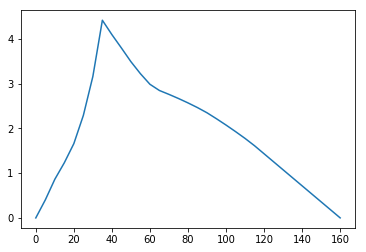

In [300]:
# get the basic flight profile from feynman outputs
# also wow this feynman data, holy floating bit math errors batman!
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

altitudes = []
machs = []
times = []

with open('feynman-results.csv') as file:
    reader = csv.DictReader(file)
    for row in reader:
        altitudes.append(float(row["Altitude (m)"]))
        machs.append(float(row["Mach Number"]))
        times.append(float(row["Times (s)"]))

P0 = []
rho0 = []
#rho here has issues/is wrong!
for alt in altitudes:
    alt=float(alt)
    if(alt<= 25000):
        P0.append(math.exp(4.43165 * math.pow(10,-14) * math.pow(alt,3) - 2.28553 * math.pow(10,-9) * pow(alt,2) - 1.14097 * pow(10,-4) * alt + 6.95109)) 
        rho0.append(math.exp(4.88158 * math.pow(10,-18) * math.pow(alt,4) - 1.808 * math.pow(10,-13) * pow(alt,3) + 2.432 * pow(10,-11) * pow(alt,2) - 9.693 * math.pow(10,-5) * alt + 0.1922))
    elif(alt<= 75000):
        P0.append(math.exp(-2.28179 * math.pow(10,-14) * math.pow(alt,3) + 3.34063 * math.pow(10,-9) * pow(alt,2) - 2.84655 * pow(10,-4) * alt + 8.73033))
        rho0.append(math.exp(-6.034 * math.pow(10,-19) * math.pow(alt,4) + 1.035 * math.pow(10,-13) * math.pow(alt,3) - 5.746 * pow(10,-9) * pow(alt,2) - 2.21 * math.pow(10,-5) * alt - 0.396))

    else:
        P0.append(math.exp(4.44813 * math.pow(10,-14) * math.pow(alt,3) - 1.13434 * math.pow(10,-8) * pow(alt,2) + 7.62651 * pow(10,-4) * alt - 15.5981))
        rho0.append(math.exp(-1.004 * math.pow(10,-18) * math.pow(alt,4) + 4.440 * math.pow(10,-13) * pow(alt,3) - 7.137 * pow(10,-8) * pow(alt,2) + 4.773 * math.pow(10,-3) * alt - 121.84))

#plt.semilogy(altitudes[::500],P0[::500])
#plt.semilogy(altitudes[::500],rho0[::500])
#plt.xticks(np.arange(testalt[0], testP[len(testP)-1]))
#plt.show()
# we'll want to graph this for the appendix

T0 = []
for alt in altitudes:
    alt=float(alt)
    if(alt<=10000):
        T0.append(287.954 - 5.03015 * 10**-3*alt - 1.2859 * 10**-7*alt**2)
    elif(alt<=23000):
        T0.append(225.15)
    elif(alt<=42000):
        T0.append(242.057 - 2.33854 * 10**-3*alt + 7.08133 * 10**-8*alt**2)
    elif(alt<=81500):
        T0.append(-534.104 + 3.95468 * 10**-2*alt - 6.0177 * 10**-7*alt**2 + 2.71838 * 10**-12*alt**3)
    elif(alt<=120000):
        T0.append(867.12 - 9.78603 * 10**-3*alt - 5.75164 * 10**-8*alt**2 + 8.81316 * 10**-13*alt**3)

plt.plot(times[::500],altitudes[::500])
plt.savefig("figures/altitude", dpi=600)
plt.clf()
plt.plot(times[::500],machs[::500])
plt.savefig("figures/machs", dpi=600)

#plt.show()


#plt.plot(u)
#plt.plot(k)



In [301]:
#A couple of constant

beta = 0.52
l = 0.3
epsilon = 0.15
sigma = 5.67*10**-8

c_skin = 921
tau_skin = 0.005
rho_skin = 2710

G=c_skin*tau_skin*rho_skin
print(G)

K= 0.89


12479.550000000001


Max temp: 348.4459774247633 K at time 65.41


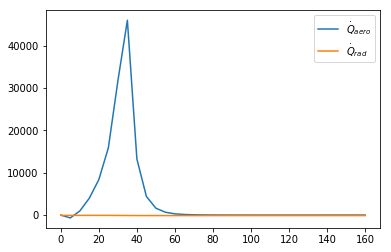

In [302]:
#initial conditions:

T_N = 300

#iterate through and solve

skintemps = []
Blayertemps = []
aeroflux = []
radflux = []
hlog = []
deltalog = []
staglog = []
skintemps.append(T_N)

maxtemp = 0
maxtemptime = 0


prevTime = float(times[0])

index = 0
for curTime in times[1:]:
    index+=1
    step = float(curTime)-prevTime

    c=math.sqrt(1.4*P0[index]/rho0[index])

    u = machs[index]*c

    mu = -1.00 * 10**-5 - 1.47 * 10**-9*T_B + 1.68 * 10**-6*T_B**0.5
    k = (-1.29 * 10**-2 + 2.43 * 10**-5*T_B - 3.39 * 10**-9*T_B**2  + 1.88 * 10**-3*T_B**0.5)

    h=(0.0071+0.0154*beta**0.5)*k/(mu**0.8*l**0.2)*rho0[index]*u

    T_s = T0[index]*(1+(1.4-1)/2*machs[index]**2)

    T_B = K*T_s+T0[index]*(1-K)

    Qdot_aero = h*(T_B-T_N)

    Qdot_rad = epsilon*sigma*(0*T0[index]**4-T_N**4)

   

    deltaT_N = step*(Qdot_aero+Qdot_rad)/G

    T_N+=deltaT_N

    skintemps.append(T_N)
    aeroflux.append(Qdot_aero)
    radflux.append(Qdot_rad)
    Blayertemps.append(T_B)
    hlog.append(h)
    deltalog.append(deltaT_N)
    staglog.append(T_s)

    if(T_N>maxtemp):
        maxtemp=T_N
        maxtemptime = times[index]

    #setup for next iter
    prevTime = float(curTime)

plt.plot(times[::100],skintemps[::100])
#plt.plot(times[::100],staglog[::100])
#plt.plot(times[::500],Blayertemps[::500])

#plt.plot(times[::500],hlog[::500])
#plt.plot(times[::500],deltalog[::500])

plt.savefig("figures/tempprofile",dpi=600)
plt.clf()

print(f"Max temp: {maxtemp} K at time {maxtemptime}")

plt.plot(times[::500],aeroflux[::500], label="$\dot{Q}_{aero}$")
plt.plot(times[::500],radflux[::500], label="$\dot{Q}_{rad}$")
plt.legend()

plt.savefig("figures/flux",dpi=600)



plt.show()
